## Dataset Curation for Testing Textual Bias in Discriminative and Contrastive Models

In this notebook, we aim to create a Texture Bias Dataset derived from the CIFAR-10 dataset. The objective is to preserve the texture information of objects while distorting their shapes. This transformation challenges models to rely more on texture rather than shape, allowing for a nuanced evaluation of semantic biases. 

#### Imports

In [6]:
import os
import random
import shutil
from pathlib import Path
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from PIL import Image, ImageFilter
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import cv2

import warnings
warnings.filterwarnings('ignore')


In [3]:
transform = transforms.Compose([transforms.ToTensor(),])

train_dataset = datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
class_names = train_dataset.classes

print("CIFAR-10 Classes:", class_names)

100%|██████████| 170498071/170498071 [00:12<00:00, 13335148.25it/s]


Extracting data/cifar-10-python.tar.gz to data
CIFAR-10 Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


For our dataset, We randomly sample 100 images from each of the 10 classes, resulting in a total of 1,000 images.

In [12]:
random.seed(42)

sampled_indices = {class_name: [] for class_name in class_names}

for idx, (image, label) in enumerate(train_dataset):
    class_name = class_names[label]
    if len(sampled_indices[class_name]) < 100:
        sampled_indices[class_name].append(idx)
    if all(len(indices) >= 100 for indices in sampled_indices.values()):
        break

for class_name, indices in sampled_indices.items():
    print(f"{class_name}: {len(indices)} images")


airplane: 100 images
automobile: 100 images
bird: 100 images
cat: 100 images
deer: 100 images
dog: 100 images
frog: 100 images
horse: 100 images
ship: 100 images
truck: 100 images


Transformation Method

To preserve texture while distorting shapes, we apply Elastic Transformations. Elastic transformations apply random displacement fields to the image, causing local distortions that preserve the global texture details of the image. Additionally, we remove the color cues from the images by converting them to grayscale so that the data is solely evaluated on textual cues.  

In [13]:
def elastic_transform(image, alpha=34, sigma=4):
    """
    Apply elastic deformation to the image and convert it to grayscale.

    Parameters:
    - image (PIL.Image): Input image.
    - alpha (float): Scaling factor for the deformation.
    - sigma (float): Gaussian filter standard deviation.

    Returns:
    - PIL.Image: Transformed grayscale image.
    """
    np_image = np.array(image)
    random_state = np.random.RandomState(None)
    shape = np_image.shape[:2]
    dx = (random_state.rand(*shape) * 2 - 1)
    dy = (random_state.rand(*shape) * 2 - 1)
    dx = gaussian_filter(dx, sigma, mode="reflect") * alpha
    dy = gaussian_filter(dy, sigma, mode="reflect") * alpha
    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    transformed = cv2.remap(np_image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    transformed_image = Image.fromarray(transformed)
    transformed_image = transformed_image.convert('L') 
    
    return transformed_image

Dataset Creation

In [14]:
ALPHA = 34  
SIGMA = 4   

output_dir = Path('texture_bias_dataset')
output_dir.mkdir(exist_ok=True)

for class_name in class_names:
    print(f"Processing class: {class_name}")
    class_output_dir = output_dir / class_name
    class_output_dir.mkdir(parents=True, exist_ok=True)

    for idx, image_idx in enumerate(sampled_indices[class_name]):

        image, label = train_dataset[image_idx]
        pil_image = transforms.ToPILImage()(image)

        transformed_image = elastic_transform(pil_image, alpha=ALPHA, sigma=SIGMA)
        transformed_image = transformed_image.filter(ImageFilter.DETAIL)

        filename = f"{idx+1:03d}.png"
        save_path = class_output_dir / filename
        transformed_image.save(save_path)

    print(f"  - Saved 100 transformed images for class '{class_name}'.")


Processing class: airplane
  - Saved 100 transformed images for class 'airplane'.
Processing class: automobile
  - Saved 100 transformed images for class 'automobile'.
Processing class: bird
  - Saved 100 transformed images for class 'bird'.
Processing class: cat
  - Saved 100 transformed images for class 'cat'.
Processing class: deer
  - Saved 100 transformed images for class 'deer'.
Processing class: dog
  - Saved 100 transformed images for class 'dog'.
Processing class: frog
  - Saved 100 transformed images for class 'frog'.
Processing class: horse
  - Saved 100 transformed images for class 'horse'.
Processing class: ship
  - Saved 100 transformed images for class 'ship'.
Processing class: truck
  - Saved 100 transformed images for class 'truck'.


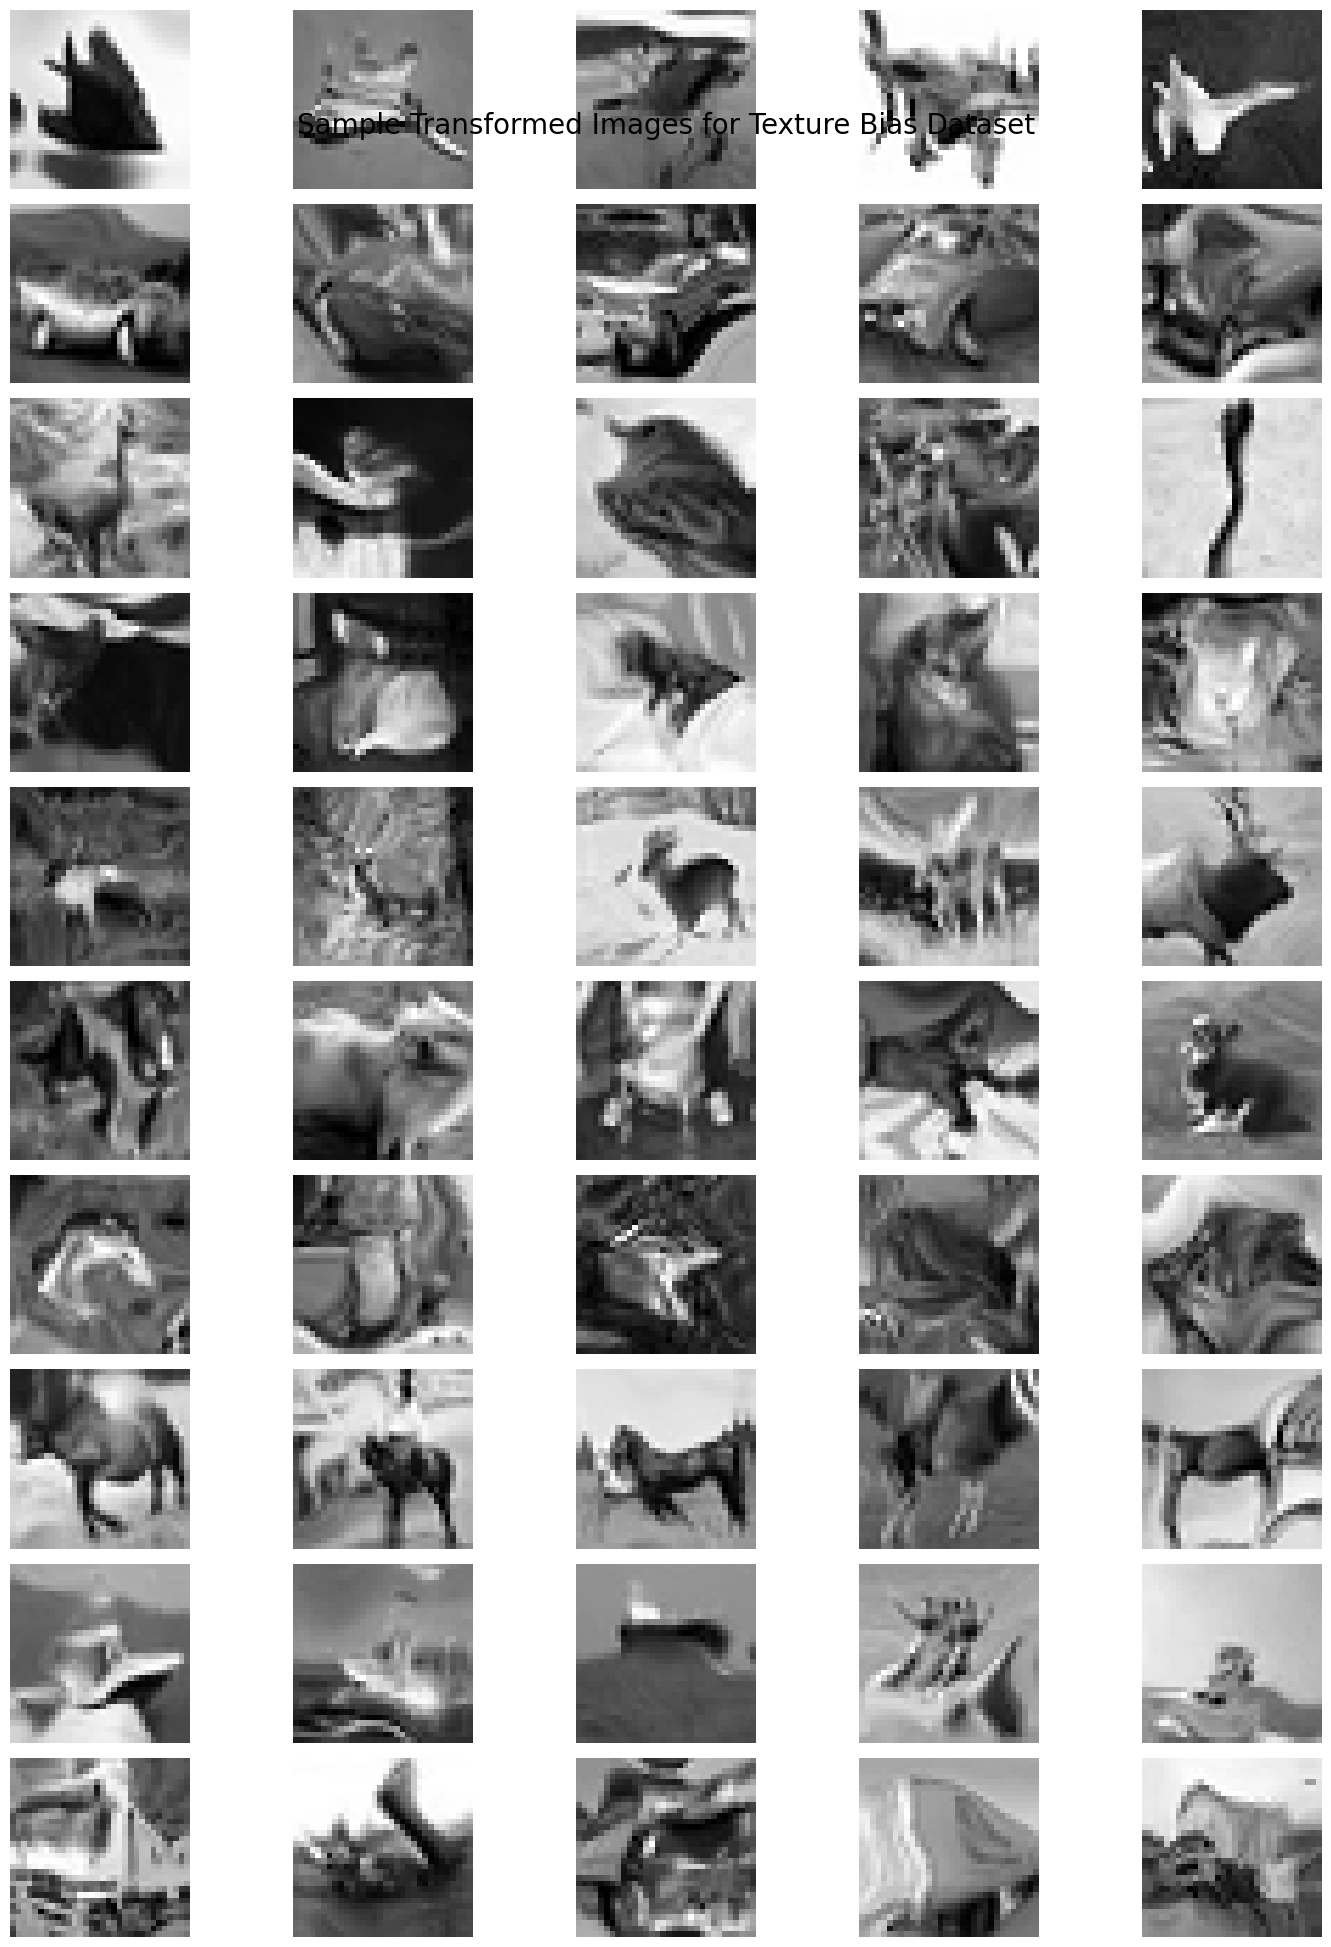

In [17]:

samples_per_class = 5

fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(15, 20))
fig.suptitle('Sample Transformed Images for Texture Bias Dataset', fontsize=20, y=0.92)

for row_idx, class_name in enumerate(class_names):
    class_dir = output_dir / class_name
    image_files = sorted(os.listdir(class_dir))[:samples_per_class]

    for col_idx, image_file in enumerate(image_files):
        img_path = class_dir / image_file
        img = Image.open(img_path)

        axes[row_idx, col_idx].imshow(img, cmap='gray')
        axes[row_idx, col_idx].axis('off')

        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(class_name, fontsize=12, rotation=0, labelpad=40, va='center')

plt.tight_layout()
plt.show()


In [16]:
from google.colab import files
import shutil

dataset_dir = 'texture_bias_dataset'
shutil.make_archive(dataset_dir, 'zip', dataset_dir)
files.download('texture_bias_dataset.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>